# FaceSwap

taken from http://matthewearl.github.io/2015/07/28/switching-eds-with-python/

We need to install dlib with opnecv bindings first as mentioned in the blog and github feed.

In [1]:
import dlib

Next we need to load the binaries needed. It turns out that the required binary for face file is already provided [here](https://www.kaggle.com/datasets/ellenfan2000/stats402emotiondetection)

In [2]:
#!wget --wait 1 "https://sourceforge.net/projects/dclib/files/latest/download" -O "shape.bz2"

In [3]:
#!du -sh shape.bz2

In [4]:
#!mv ./download.out ./download.bz2

In [5]:
#!bunzip2 ./shape.bz2

# Importing required libs

In [6]:
import cv2
import dlib
import numpy
import sys

In [7]:
PREDICTOR_PATH="../input/stats402emotiondetection/shape_predictor_68_face_landmarks.dat"

Giving values to constants

In [8]:
SCALE_FACTOR = 1 
FEATHER_AMOUNT = 11

FACE_POINTS = list(range(17, 68))
MOUTH_POINTS = list(range(48, 61))
RIGHT_BROW_POINTS = list(range(17, 22))
LEFT_BROW_POINTS = list(range(22, 27))
RIGHT_EYE_POINTS = list(range(36, 42))
LEFT_EYE_POINTS = list(range(42, 48))
NOSE_POINTS = list(range(27, 35))
JAW_POINTS = list(range(0, 17))

# Points used to line up the images.
ALIGN_POINTS = (LEFT_BROW_POINTS + RIGHT_EYE_POINTS + LEFT_EYE_POINTS +
                               RIGHT_BROW_POINTS + NOSE_POINTS + MOUTH_POINTS)

# Points from the second image to overlay on the first. The convex hull of each
# element will be overlaid.
OVERLAY_POINTS = [
    LEFT_EYE_POINTS + RIGHT_EYE_POINTS + LEFT_BROW_POINTS + RIGHT_BROW_POINTS,
    NOSE_POINTS + MOUTH_POINTS,
]

# Amount of blur to use during colour correction, as a fraction of the
# pupillary distance.
COLOUR_CORRECT_BLUR_FRAC = 0.6


Initializing the detetctor and predictor.

In [9]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)

In [10]:
class TooManyFaces(Exception):
    pass

class NoFaces(Exception):
    pass

In [11]:
def get_landmarks(im):
    rects = detector(im, 1)
    
    if len(rects) > 1:
        raise TooManyFaces
    
    if len(rects) == 0:
        raise NoFaces
    
    return numpy.matrix([[p.x, p.y] for p in predictor(im, rects[0]).parts()])

In [12]:
def annotate_landmarks(im, landmarks):
    im = im.copy()
    for idx, point in enumerate(landmarks):
        pos = (point[0, 0], point[0, 1])
        cv2.putText(im, str(idx), pos,
                    fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
                    fontScale=0.4,
                    color=(0, 0, 255))
        cv2.circle(im, pos, 3, color=(0, 255, 255))
    return im

In [13]:
def draw_convex_hull(im, points, color):
    points = cv2.convexHull(points)
    cv2.fillConvexPoly(im, points, color=color)

In [14]:
def get_face_mask(im, landmarks):
    im = numpy.zeros(im.shape[:2], dtype=numpy.float64)

    for group in OVERLAY_POINTS:
        draw_convex_hull(im,
                         landmarks[group],
                         color=1)

    im = numpy.array([im, im, im]).transpose((1, 2, 0))

    im = (cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0) > 0) * 1.0
    im = cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0)

    return im

The orthogonal Procrustes problem [1] is a matrix approximation problem in linear algebra. In its classical form, one is given two matrices {\displaystyle A}A and {\displaystyle B}B and asked to find an orthogonal matrix {\displaystyle \Omega }\Omega  which most closely maps {\displaystyle A}A to {\displaystyle B}B. [2][3]

In [15]:
def transformation_from_points(points1, points2):
    """
    Return an affine transformation [s * R | T] such that:
        sum ||s*R*p1,i + T - p2,i||^2
    is minimized.
    """
    # Solve the procrustes problem by subtracting centroids, scaling by the
    # standard deviation, and then using the SVD to calculate the rotation. See
    # the following for more details:
    #   https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem

    points1 = points1.astype(numpy.float64)
    points2 = points2.astype(numpy.float64)

    c1 = numpy.mean(points1, axis=0)
    c2 = numpy.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2

    s1 = numpy.std(points1)
    s2 = numpy.std(points2)
    points1 /= s1
    points2 /= s2

    U, S, Vt = numpy.linalg.svd(points1.T * points2)

    # The R we seek is in fact the transpose of the one given by U * Vt. This
    # is because the above formulation assumes the matrix goes on the right
    # (with row vectors) where as our solution requires the matrix to be on the
    # left (with column vectors).
    R = (U * Vt).T

    return numpy.vstack([numpy.hstack(((s2 / s1) * R,
                                       c2.T - (s2 / s1) * R * c1.T)),
                         numpy.matrix([0., 0., 1.])])


In [16]:
def read_im_and_landmarks(fname):
    im = cv2.imread(fname, cv2.IMREAD_COLOR)
    im = cv2.resize(im, (im.shape[1] * SCALE_FACTOR,
                         im.shape[0] * SCALE_FACTOR))
    s = get_landmarks(im)

    return im, s


In [17]:
def warp_im(im, M, dshape):
    output_im = numpy.zeros(dshape, dtype=im.dtype)
    cv2.warpAffine(im,
                   M[:2],
                   (dshape[1], dshape[0]),
                   dst=output_im,
                   borderMode=cv2.BORDER_TRANSPARENT,
                   flags=cv2.WARP_INVERSE_MAP)
    return output_im

In [18]:
def correct_colours(im1, im2, landmarks1):
    blur_amount = COLOUR_CORRECT_BLUR_FRAC * numpy.linalg.norm(
                              numpy.mean(landmarks1[LEFT_EYE_POINTS], axis=0) -
                              numpy.mean(landmarks1[RIGHT_EYE_POINTS], axis=0))
    blur_amount = int(blur_amount)
    if blur_amount % 2 == 0:
        blur_amount += 1
    im1_blur = cv2.GaussianBlur(im1, (blur_amount, blur_amount), 0)
    im2_blur = cv2.GaussianBlur(im2, (blur_amount, blur_amount), 0)

    # Avoid divide-by-zero errors.
    im2_blur += (128 * (im2_blur <= 1.0)).astype(im2_blur.dtype)

    return (im2.astype(numpy.float64) * im1_blur.astype(numpy.float64) /
                                                im2_blur.astype(numpy.float64))

In [19]:
!wget "https://i.guim.co.uk/img/media/5ed54edd5d9d620487c523150e4672e3df43e442/0_197_3000_1800/master/3000.jpg?width=445&quality=45&auto=format&fit=max&dpr=2&s=6c6f3150304ee7cb339dbf5edf03eebb" -O trump.jpg

--2022-04-04 16:31:20--  https://i.guim.co.uk/img/media/5ed54edd5d9d620487c523150e4672e3df43e442/0_197_3000_1800/master/3000.jpg?width=445&quality=45&auto=format&fit=max&dpr=2&s=6c6f3150304ee7cb339dbf5edf03eebb
Resolving i.guim.co.uk (i.guim.co.uk)... 199.232.33.111, 2a04:4e42:45::367
Connecting to i.guim.co.uk (i.guim.co.uk)|199.232.33.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12371 (12K) [image/jpeg]
Saving to: ‘trump.jpg’

trump.jpg           100%[===================>]  12.08K  --.-KB/s    in 0.001s  

2022-04-04 16:31:20 (18.0 MB/s) - ‘trump.jpg’ saved [12371/12371]



In [20]:
!wget "https://ca-times.brightspotcdn.com/dims4/default/be3a23e/2147483647/strip/true/crop/3648x2555+0+0/resize/840x588!/quality/90/?url=https%3A%2F%2Fcalifornia-times-brightspot.s3.amazonaws.com%2Fcd%2F77%2Fe2cb3f604c489a94c218e7dd143a%2Fpeople-will-smith-67445.jpg" -O will.jpg

--2022-04-04 16:31:20--  https://ca-times.brightspotcdn.com/dims4/default/be3a23e/2147483647/strip/true/crop/3648x2555+0+0/resize/840x588!/quality/90/?url=https%3A%2F%2Fcalifornia-times-brightspot.s3.amazonaws.com%2Fcd%2F77%2Fe2cb3f604c489a94c218e7dd143a%2Fpeople-will-smith-67445.jpg
Resolving ca-times.brightspotcdn.com (ca-times.brightspotcdn.com)... 18.64.236.75, 18.64.236.82, 18.64.236.109, ...
Connecting to ca-times.brightspotcdn.com (ca-times.brightspotcdn.com)|18.64.236.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92936 (91K) [image/jpeg]
Saving to: ‘will.jpg’

will.jpg            100%[===================>]  90.76K  --.-KB/s    in 0.02s   

2022-04-04 16:31:21 (5.68 MB/s) - ‘will.jpg’ saved [92936/92936]



In [21]:
!dir

__notebook__.ipynb  trump.jpg  will.jpg


In [22]:
im1, landmarks1 = read_im_and_landmarks('./trump.jpg')
im2, landmarks2 = read_im_and_landmarks('./will.jpg')

In [23]:
im1.shape, im2.shape

((534, 890, 3), (588, 840, 3))

In [24]:
import matplotlib.pyplot as plt

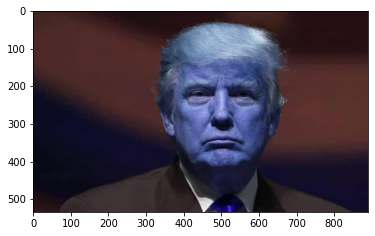

In [25]:
plt.imshow(im1)

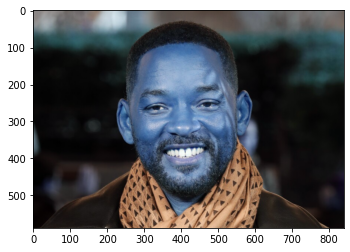

In [26]:
plt.imshow(im2)

In [27]:
M = transformation_from_points(landmarks1[ALIGN_POINTS],
                               landmarks2[ALIGN_POINTS])

mask = get_face_mask(im2, landmarks2)
warped_mask = warp_im(mask, M, im1.shape)
combined_mask = numpy.max([get_face_mask(im1, landmarks1), warped_mask],
                          axis=0)

In [28]:
warped_im2 = warp_im(im2, M, im1.shape)
warped_corrected_im2 = correct_colours(im1, warped_im2, landmarks1)

output_im = im1 * (1.0 - combined_mask) + warped_corrected_im2 * combined_mask

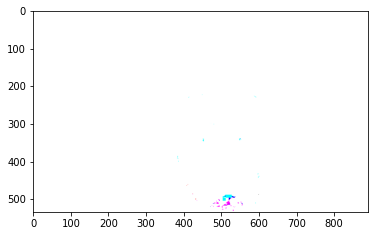

In [29]:
plt.imshow(output_im)

It didnt quite work lets try to get the github repo itself.

In [30]:
!git clone https://github.com/matthewearl/faceswap

Cloning into 'faceswap'...
remote: Enumerating objects: 32, done.
remote: Total 32 (delta 0), reused 0 (delta 0), pack-reused 32
Unpacking objects: 100% (32/32), 7.98 KiB | 1.14 MiB/s, done.


In [31]:
!dir

__notebook__.ipynb  faceswap  trump.jpg  will.jpg


In [32]:
new_code = '''
#!/usr/bin/python

# Copyright (c) 2015 Matthew Earl
# 
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
# 
#     The above copyright notice and this permission notice shall be included
#     in all copies or substantial portions of the Software.
# 
#     THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS
#     OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF
#     MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN
#     NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM,
#     DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR
#     OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE
#     USE OR OTHER DEALINGS IN THE SOFTWARE.

"""
This is the code behind the Switching Eds blog post:

    http://matthewearl.github.io/2015/07/28/switching-eds-with-python/

See the above for an explanation of the code below.

To run the script you'll need to install dlib (http://dlib.net) including its
Python bindings, and OpenCV. You'll also need to obtain the trained model from
sourceforge:

    http://sourceforge.net/projects/dclib/files/dlib/v18.10/shape_predictor_68_face_landmarks.dat.bz2

Unzip with `bunzip2` and change `PREDICTOR_PATH` to refer to this file. The
script is run like so:

    ./faceswap.py <head image> <face image>

If successful, a file `output.jpg` will be produced with the facial features
from `<head image>` replaced with the facial features from `<face image>`.

"""

import cv2
import dlib
import numpy

import sys

PREDICTOR_PATH = "./shape_predictor_68_face_landmarks.dat"
SCALE_FACTOR = 1 
FEATHER_AMOUNT = 11

FACE_POINTS = list(range(17, 68))
MOUTH_POINTS = list(range(48, 61))
RIGHT_BROW_POINTS = list(range(17, 22))
LEFT_BROW_POINTS = list(range(22, 27))
RIGHT_EYE_POINTS = list(range(36, 42))
LEFT_EYE_POINTS = list(range(42, 48))
NOSE_POINTS = list(range(27, 35))
JAW_POINTS = list(range(0, 17))

# Points used to line up the images.
ALIGN_POINTS = (LEFT_BROW_POINTS + RIGHT_EYE_POINTS + LEFT_EYE_POINTS +
                               RIGHT_BROW_POINTS + NOSE_POINTS + MOUTH_POINTS)

# Points from the second image to overlay on the first. The convex hull of each
# element will be overlaid.
OVERLAY_POINTS = [
    LEFT_EYE_POINTS + RIGHT_EYE_POINTS + LEFT_BROW_POINTS + RIGHT_BROW_POINTS,
    NOSE_POINTS + MOUTH_POINTS,
]

# Amount of blur to use during colour correction, as a fraction of the
# pupillary distance.
COLOUR_CORRECT_BLUR_FRAC = 0.6

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)

class TooManyFaces(Exception):
    pass

class NoFaces(Exception):
    pass

def get_landmarks(im):
    rects = detector(im, 1)
    
    if len(rects) > 1:
        raise TooManyFaces
    if len(rects) == 0:
        raise NoFaces

    return numpy.matrix([[p.x, p.y] for p in predictor(im, rects[0]).parts()])

def annotate_landmarks(im, landmarks):
    im = im.copy()
    for idx, point in enumerate(landmarks):
        pos = (point[0, 0], point[0, 1])
        cv2.putText(im, str(idx), pos,
                    fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
                    fontScale=0.4,
                    color=(0, 0, 255))
        cv2.circle(im, pos, 3, color=(0, 255, 255))
    return im

def draw_convex_hull(im, points, color):
    points = cv2.convexHull(points)
    cv2.fillConvexPoly(im, points, color=color)

def get_face_mask(im, landmarks):
    im = numpy.zeros(im.shape[:2], dtype=numpy.float64)

    for group in OVERLAY_POINTS:
        draw_convex_hull(im,
                         landmarks[group],
                         color=1)

    im = numpy.array([im, im, im]).transpose((1, 2, 0))

    im = (cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0) > 0) * 1.0
    im = cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0)

    return im
    
def transformation_from_points(points1, points2):
    """
    Return an affine transformation [s * R | T] such that:

        sum ||s*R*p1,i + T - p2,i||^2

    is minimized.

    """
    # Solve the procrustes problem by subtracting centroids, scaling by the
    # standard deviation, and then using the SVD to calculate the rotation. See
    # the following for more details:
    #   https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem

    points1 = points1.astype(numpy.float64)
    points2 = points2.astype(numpy.float64)

    c1 = numpy.mean(points1, axis=0)
    c2 = numpy.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2

    s1 = numpy.std(points1)
    s2 = numpy.std(points2)
    points1 /= s1
    points2 /= s2

    U, S, Vt = numpy.linalg.svd(points1.T * points2)

    # The R we seek is in fact the transpose of the one given by U * Vt. This
    # is because the above formulation assumes the matrix goes on the right
    # (with row vectors) where as our solution requires the matrix to be on the
    # left (with column vectors).
    R = (U * Vt).T

    return numpy.vstack([numpy.hstack(((s2 / s1) * R,
                                       c2.T - (s2 / s1) * R * c1.T)),
                         numpy.matrix([0., 0., 1.])])

def read_im_and_landmarks(fname):
    im = cv2.imread(fname, cv2.IMREAD_COLOR)
    im = cv2.resize(im, (im.shape[1] * SCALE_FACTOR,
                         im.shape[0] * SCALE_FACTOR))
    s = get_landmarks(im)

    return im, s

def warp_im(im, M, dshape):
    output_im = numpy.zeros(dshape, dtype=im.dtype)
    cv2.warpAffine(im,
                   M[:2],
                   (dshape[1], dshape[0]),
                   dst=output_im,
                   borderMode=cv2.BORDER_TRANSPARENT,
                   flags=cv2.WARP_INVERSE_MAP)
    return output_im

def correct_colours(im1, im2, landmarks1):
    blur_amount = COLOUR_CORRECT_BLUR_FRAC * numpy.linalg.norm(
                              numpy.mean(landmarks1[LEFT_EYE_POINTS], axis=0) -
                              numpy.mean(landmarks1[RIGHT_EYE_POINTS], axis=0))
    blur_amount = int(blur_amount)
    if blur_amount % 2 == 0:
        blur_amount += 1
    im1_blur = cv2.GaussianBlur(im1, (blur_amount, blur_amount), 0)
    im2_blur = cv2.GaussianBlur(im2, (blur_amount, blur_amount), 0)

    # Avoid divide-by-zero errors.
    im2_blur += (128 * (im2_blur <= 1.0)).astype(im2_blur.dtype)

    return (im2.astype(numpy.float64) * im1_blur.astype(numpy.float64) /
                                                im2_blur.astype(numpy.float64))

im1, landmarks1 = read_im_and_landmarks(sys.argv[1])
im2, landmarks2 = read_im_and_landmarks(sys.argv[2])

M = transformation_from_points(landmarks1[ALIGN_POINTS],
                               landmarks2[ALIGN_POINTS])

mask = get_face_mask(im2, landmarks2)
warped_mask = warp_im(mask, M, im1.shape)
combined_mask = numpy.max([get_face_mask(im1, landmarks1), warped_mask],
                          axis=0)

warped_im2 = warp_im(im2, M, im1.shape)
warped_corrected_im2 = correct_colours(im1, warped_im2, landmarks1)

output_im = im1 * (1.0 - combined_mask) + warped_corrected_im2 * combined_mask

cv2.imwrite('output.jpg', output_im)

'''


In [33]:
!echo {new_code}


bunzip2: I won't read compressed data from a terminal.
bunzip2: For help, type: `bunzip2 --help'.
/bin/bash: line 44: PREDICTOR_PATH: command not found
/bin/bash: line 44: output.jpg: command not found
/bin/bash: command substitution: line 44: syntax error near unexpected token `newline'
/bin/bash: command substitution: line 44: `<head image>'
/bin/bash: command substitution: line 44: syntax error near unexpected token `newline'
/bin/bash: command substitution: line 44: `<face image>'
/bin/bash: line 44: 
This is the code behind the Switching Eds blog post:

    http://matthewearl.github.io/2015/07/28/switching-eds-with-python/

See the above for an explanation of the code below.

To run the script you'll need to install dlib (http://dlib.net) including its
Python bindings, and OpenCV. You'll also need to obtain the trained model from
sourceforge:

    http://sourceforge.net/projects/dclib/files/dlib/v18.10/shape_predictor_68_face_landmarks.dat.bz2

Unzip with  and change  to refer to

In [34]:
!echo {new_code} > new.py


bunzip2: I won't read compressed data from a terminal.
bunzip2: For help, type: `bunzip2 --help'.
/bin/bash: line 44: PREDICTOR_PATH: command not found
/bin/bash: line 44: output.jpg: command not found
/bin/bash: command substitution: line 44: syntax error near unexpected token `newline'
/bin/bash: command substitution: line 44: `<head image>'
/bin/bash: command substitution: line 44: syntax error near unexpected token `newline'
/bin/bash: command substitution: line 44: `<face image>'
/bin/bash: line 44: 
This is the code behind the Switching Eds blog post:

    http://matthewearl.github.io/2015/07/28/switching-eds-with-python/

See the above for an explanation of the code below.

To run the script you'll need to install dlib (http://dlib.net) including its
Python bindings, and OpenCV. You'll also need to obtain the trained model from
sourceforge:

    http://sourceforge.net/projects/dclib/files/dlib/v18.10/shape_predictor_68_face_landmarks.dat.bz2

Unzip with  and change  to refer to

In [35]:
!python .new.py trump.jpg will.jpg

python: can't open file '.new.py': [Errno 2] No such file or directory
